# Visualize Experiment Results
This notebook demonstrates how to use the `ResultHandler` to load experiment results.

In [1]:
import os
from pathlib import Path

project_root = Path.cwd().parent
if Path.cwd() != project_root:
    os.chdir(project_root)

from src.utils.resultHandler import ResultHandler
import matplotlib.pyplot as plt
from src.utils.configHandler import ConfigHandler

plt.style.use(os.path.join(os.getcwd(), "configs", "visualisations.mplstyle"))

_config_handler = ConfigHandler()
rh = ResultHandler(_config_handler.SUMMARY_FILE)

folders = rh.get_result_folders()
rh.logger.info(f"Found {len(folders)} result folders.")
folders[:5]

2025-07-23 14:44:54,322 - INFO - src.utils.configHandler - Initializing ConfigHandler with paths_yaml_path: configs/paths.yaml
2025-07-23 14:44:54,323 - INFO - src.utils.configHandler - Successfully loaded paths configuration from YAML file
2025-07-23 14:44:54,326 - INFO - src.utils.resultHandler - Initialized ResultHandler with summary_csv_path: results/summary.csv
2025-07-23 14:44:54,326 - INFO - src.utils.resultHandler - Found 325 result folders.


['results/2025-07-23_12-23-40',
 'results/2025-07-23_12-23-40',
 'results/2025-07-23_12-23-40',
 'results/2025-07-23_12-23-40',
 'results/2025-07-23_12-23-41']

In [3]:
import pandas as pd
from ipywidgets import interact, FloatSlider, Dropdown, Checkbox, fixed

# Filter results for label flipping strategy with random mode
subset_results_label_flipping = rh.summary_df[
    (rh.summary_df["strategy"] == "label_flipping")
    & (rh.summary_df["strategy_mode"] == "random")
]
subset_results_label_flipping = subset_results_label_flipping.sort_values(
    by=["dataset", "classifier", "strategy", "strategy_mode", "strategy_params"]
)

# Expand the strategy_params column to separate columns
subset_results_label_flipping["strategy_params"] = subset_results_label_flipping[
    "strategy_params"
].apply(eval)
strategy_params_expanded = subset_results_label_flipping["strategy_params"].apply(
    pd.Series
)
subset_results_label_flipping = pd.concat(
    [subset_results_label_flipping, strategy_params_expanded], axis=1
)

# Create checkboxes for each dataset
dataset_names = subset_results_label_flipping["dataset"].unique()
dataset_checkboxes = {
    name: Checkbox(value=True, description=name) for name in dataset_names
}

In [4]:
def plot_accuracy_vs_flip_ratio(
    classifier, prepare_save_plot: bool = False, **datasets_selected
):
    fig, ax = plt.subplots()
    flip_ratios = sorted(subset_results_label_flipping["flip_ratio"].unique())

    for dataset in dataset_names:
        if not datasets_selected.get(dataset, True):
            continue
        ds = subset_results_label_flipping[
            (subset_results_label_flipping["dataset"] == dataset)
            & (subset_results_label_flipping["classifier"] == classifier)
        ]
        if ds.empty:
            continue

        means, stds, valid_flip_ratios = [], [], []
        for fr in flip_ratios:
            fr_ds = ds[ds["flip_ratio"] == fr]
            if fr_ds.empty:
                continue
            grouped = fr_ds.groupby("random_seed")["accuracy"].mean()
            means.append(grouped.mean())
            stds.append(grouped.std())
            valid_flip_ratios.append(fr)

        if valid_flip_ratios:
            ax.errorbar(
                valid_flip_ratios,
                means,
                yerr=stds,
                fmt="-o",
                label=dataset,
                capsize=4,
                markersize=6,
            )

    ax.set_xlabel("Flip Ratio")
    ax.set_ylabel(f"{classifier} Accuracy")
    ax.set_title(f"{classifier} Accuracy vs. Flip Ratio")
    ax.set_xlim(min(flip_ratios), max(flip_ratios))
    ax.set_ylim(0, 1)
    ax.legend()
    plt.show()

    if prepare_save_plot:
        return fig


_ = interact(
    plot_accuracy_vs_flip_ratio,
    classifier=Dropdown(
        options=subset_results_label_flipping["classifier"].unique(),
        description="Classifier",
    ),
    prepare_save_plot=fixed(False),
    **dataset_checkboxes,
)

interactive(children=(Dropdown(description='Classifier', options=('catch22', 'mini-rocket'), value='catch22'),…

In [ ]:
def plot_accuracy_comparison(
    flip_ratio,
    classifier1,
    classifier2,
    prepare_save_plot: bool = False,
    **datasets_selected,
):

    subset = subset_results_label_flipping[
        subset_results_label_flipping["flip_ratio"] == flip_ratio
    ]
    if subset.empty:
        print(f"No results found for flip ratio {flip_ratio}.")
        return

    subset = subset[subset["classifier"].isin([classifier1, classifier2])]
    if subset.empty or not all(
        c in subset["classifier"].values for c in [classifier1, classifier2]
    ):
        print(
            f"Not enough results for classifiers {classifier1} and {classifier2} at flip ratio {flip_ratio}."
        )
        return

    fig, ax = plt.subplots(figsize=(6, 6))

    for dataset in subset["dataset"].unique():
        if not datasets_selected.get(dataset, True):
            continue
        ds = subset[subset["dataset"] == dataset]
        if ds.empty:
            continue

        grouped = ds.groupby(["random_seed", "classifier"])["accuracy"].mean().unstack()
        if classifier1 not in grouped or classifier2 not in grouped:
            continue
        x = grouped[classifier1]
        y = grouped[classifier2]

        if len(grouped) > 1:
            plt.errorbar(
                x.mean(),
                y.mean(),
                xerr=x.std(),
                yerr=y.std(),
                fmt="o",
                label=dataset,
                capsize=5,
                markersize=8,
            )
        else:
            ax.scatter(x, y, label=dataset, s=50)

    ax.set_xlabel(classifier1 + " Accuracy")
    ax.set_ylabel(classifier2 + " Accuracy")
    ax.set_title(f"Accuracy Comparison at Flip Ratio {flip_ratio}")
    ax.axline((0, 0), slope=1, color="grey", linestyle="--")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.legend()
    plt.show()

    if prepare_save_plot:
        return fig


_ = interact(
    plot_accuracy_comparison,
    flip_ratio=FloatSlider(
        value=0.1,
        min=float(subset_results_label_flipping["flip_ratio"].min()),
        max=float(subset_results_label_flipping["flip_ratio"].max()),
        step=0.1,
        description="Flip Ratio",
    ),
    classifier1=Dropdown(
        options=subset_results_label_flipping["classifier"].unique(),
        description="Classifier 1",
    ),
    classifier2=Dropdown(
        options=subset_results_label_flipping["classifier"].unique(),
        description="Classifier 2",
    ),
    prepare_save_plot=fixed(False),
    **dataset_checkboxes,
)

interactive(children=(FloatSlider(value=0.1, description='Flip Ratio', max=1.0), Dropdown(description='Classif…

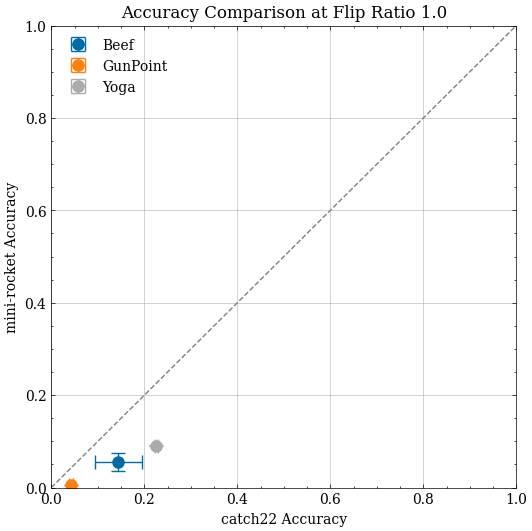

In [10]:
flip_ratio = 1.0

fig = plot_accuracy_comparison(
    classifier1=subset_results_label_flipping["classifier"].unique()[0],
    classifier2=subset_results_label_flipping["classifier"].unique()[1],
    flip_ratio=flip_ratio,
    prepare_save_plot=True,
    **{name: True for name in dataset_names},
)

fig.savefig(
    os.path.join(os.getcwd(), "figures", f"plot_accuracy_comparison_{flip_ratio}.pdf"),
    dpi=300,
)

In [ ]:
def plot_accuracy_trajectory(
    classifier1,
    classifier2,
    prepare_save_plot: bool = False,
    **datasets_selected,
):
    fig, ax = plt.subplots(figsize=(6, 6))
    flip_ratios = sorted(subset_results_label_flipping["flip_ratio"].unique())

    for dataset in dataset_names:
        if not datasets_selected.get(dataset, True):
            continue
        ds = subset_results_label_flipping[
            (subset_results_label_flipping["dataset"] == dataset)
            & (
                subset_results_label_flipping["classifier"].isin(
                    [classifier1, classifier2]
                )
            )
        ]
        if ds.empty:
            continue

        x_means, y_means, x_stds, y_stds = [], [], [], []
        valid_flip_ratios = []

        for fr in flip_ratios:
            fr_ds = ds[ds["flip_ratio"] == fr]
            grouped = (
                fr_ds.groupby(["random_seed", "classifier"])["accuracy"]
                .mean()
                .unstack()
            )
            if (
                grouped is None
                or classifier1 not in grouped
                or classifier2 not in grouped
            ):
                continue
            x = grouped[classifier1]
            y = grouped[classifier2]
            if len(x) == 0 or len(y) == 0:
                continue
            x_means.append(x.mean())
            y_means.append(y.mean())
            x_stds.append(x.std())
            y_stds.append(y.std())
            valid_flip_ratios.append(fr)

        if valid_flip_ratios:
            plt.errorbar(
                x_means,
                y_means,
                xerr=x_stds,
                yerr=y_stds,
                fmt="-o",
                label=dataset,
                capsize=3,
                markersize=5,
            )

    ax.set_xlabel(classifier1 + " Accuracy")
    ax.set_ylabel(classifier2 + " Accuracy")
    ax.set_title(
        f"Accuracy Trajectory Across Flip Ratios (from {min(flip_ratios)} to {max(flip_ratios)})"
    )
    ax.axline((0, 0), slope=1, color="grey", linestyle="--")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.legend()
    plt.show()

    if prepare_save_plot:
        return fig


_ = interact(
    plot_accuracy_trajectory,
    classifier1=Dropdown(
        options=subset_results_label_flipping["classifier"].unique(),
        description="Classifier 1",
    ),
    classifier2=Dropdown(
        options=subset_results_label_flipping["classifier"].unique(),
        description="Classifier 2",
    ),
    prepare_save_plot=fixed(False),
    **dataset_checkboxes,
)

interactive(children=(Dropdown(description='Classifier 1', options=('catch22', 'mini-rocket'), value='catch22'…

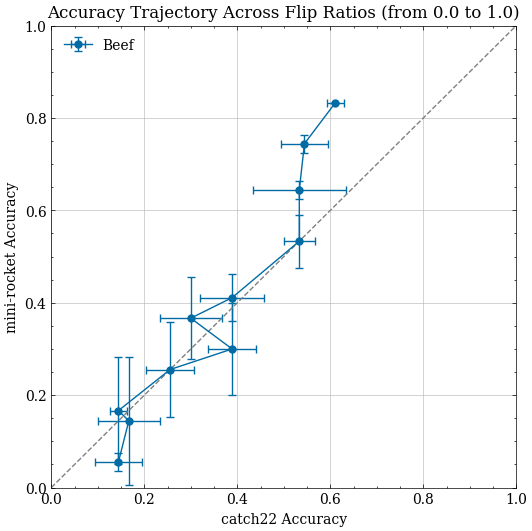

In [ ]:
classifier1 = subset_results_label_flipping["classifier"].unique()[0]
classifier2 = subset_results_label_flipping["classifier"].unique()[1]
data_set = subset_results_label_flipping["dataset"].unique()[0]

fig = plot_accuracy_trajectory(
    classifier1=classifier1,
    classifier2=classifier2,
    prepare_save_plot=True,
    **{name: False if name != data_set else True for name in dataset_names},
)

fig.savefig(
    os.path.join(
        os.getcwd(),
        "figures",
        f"plot_accuracy_trajectory_{classifier1}_{classifier2}_{data_set}.pdf",
    ),
    dpi=300,
)